In [27]:
import math

from scipy import constants as const
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# SIMULATION PARAMETERS
n = 13 # Number of auxliary stochastic variables
b = 5 # Scaling dilation parameter that determines the low cutoff frequency ν_0*b^-n
c = 1.78167 # a prefactor that depends on the particular choice of b
v_0 = 1e3 # High cutoff frequency (already scaled by tao_c)
a = 2.726e-6 # Particle size
eta = 0.36e-3 # ACETONE 1e-3 # Viscosity of water
rho_bati = 4400
rho_silica = 2200 # Density of silica
rho_acetone = 789
rho_f = 1000 # Density of water

mass = (4 / 3) * math.pi * a** 3 * rho_bati
mass_total = mass + .5 * (4 / 3) * math.pi * a**3 * rho_acetone # Mass plus added mass

temp = 293.8
K = 9.384e-5 # Need to adjust

lag_fraction = 1
sample_rate = 1 # Leave at 1 in preference of binning (sampling inside the simulation)
simulation_number = 1 # Num of traces

# # ANALYTICAL PARAMETERS
# c_water = 1500
# c_acetone = 1174
# bulk_acetone = 1.4e-3
# # bulk = 2.5E-3
#
# VSP_length = 1000
# integ_points = 10 ** 4 * 8

# start = -10
# time_range = (start, stop)
# time_points = 600

stop = -2
# stop = -1

# HELPER PARAMETERS
timestep = 1E-4  # Simulation timestep
gamma = 6*math.pi*a*eta # Steady-state friction coefficient of the particle
tao_c = (mass_total/gamma) # Momentum relaxation time of the particle

real_timestep = timestep * tao_c  # Real-world time step in seconds
print(f"Real-world time step: {real_timestep:.3e} s ({real_timestep*1e9:.2f} ns)")
print(f"Momentum relaxation time is : {tao_c:.3e} s")

#tao_f = (rho_acetone * (a ** 2)) / (eta)  # Characteristic time for vorticy diffusion across length of sphere
tao_f = (9*tao_c/(2*(rho_bati/rho_acetone)+1))
tao_fc = tao_f/tao_c

v_c = math.sqrt((const.k*temp)/mass_total) # Scales velocity before saving
x_c = tao_c*v_c # Scales Position before saving
f_c = (const.k*temp)/x_c

v_i = [(v_0/(b**(i))) for i in range(1, n+1)] # Decaying samples from an exponential distribution ...
gamma_i = [((x_c/f_c)/tao_c)*(0.5*gamma*c*math.sqrt(tao_fc/math.pi)*(v_i[i]**(3.0/2.0))) for i in range(n)]
gamma_0 = 0.5*gamma*c*math.sqrt(tao_fc/math.pi)*sum(math.sqrt(v) for v in v_i)
delta = gamma_0/gamma

print("delta is " + str(delta) + " velauto is " + str(1-(1+delta)*timestep))

trace_length = int((10**stop)/(timestep*tao_c))

df = pd.DataFrame({
    'CreationDate': [pd.Timestamp.now()],
    'a': [a],
    'eta': [eta],
    'rho_bati': [rho_bati],
    'rho_f': [rho_acetone],
    'sampling_rate': [(1.0/timestep)],
    'stop': [stop],
    # 'start': [start],
    'track_len': [trace_length],
    'sample_rate': [sample_rate],
    'tao_c': [tao_c],
    'v_c': [v_c],
    'x_c': [x_c],
    'real_timestep_s': [real_timestep]
})

# # Run the analytics
# sol = Analytical_Solution(rho_acetone, c_acetone, eta, bulk_acetone, a, rho_bati, K, tao_f, mass, mass_total, gamma, temp, VSP_length, integ_points, time_range=time_range, time_points=time_points, sample_rate=sample_rate)
# times, freq, VPSD_iw, PSD_iw, VACF_iw, PACF_iw, TPSD_iw = sol.calculate()

# Single step variables
curr_x = None
curr_v = None
curr_u = None

# Memory for single time trace
all_x = None
all_v = None
all_u = None


# reset_trace() should be called at the end of simulating a single time trace. It will
# set the variables to initial conditions, add the time trace correlation function and
# MSD to memory, and clear the last time trace from memory
def reset_trace(trace_len):
    global curr_x, curr_v, curr_u, all_x, all_v, all_u
    curr_x = 0
    curr_v = 0
    curr_u = [np.random.normal(0, math.sqrt(var)) for var in gamma_i]

    # Allocate arrays and set first value
    all_x = np.zeros(trace_len)
    all_x[0] = curr_x
    all_v = np.zeros(trace_len)
    all_v[0] = curr_v
    all_u = np.empty(trace_len, dtype=object)
    all_u[0] = curr_u

# Begin stepping. At each step we generate N+1 random numbers from the standard
# normal distribution. We use these to calculate u, v, and x. We save the values from this state and
# continue on tho generate the next state.
def compute_next_state(state_ind):

    global curr_x, curr_v, curr_u, all_x, all_v, all_u
    this_u, this_v, this_x = curr_u, curr_v, curr_x

    for k in range(sample_rate):
        # N_i = np.random.normal(0,1, n+1)
        N_i = np.random.uniform(-np.sqrt(3),np.sqrt(3), n+1)
        N_0 = sum([math.sqrt(gamma_i[j]/(v_i[j]*delta))*N_i[j] for j in range(n)])
        next_u = [((1 - v_i[j]*timestep)*this_u[j] - gamma_i[j]*timestep*this_v +
                   math.sqrt(2*gamma_i[j]*v_i[j]*timestep)*N_i[j]) for j in range(n)]
        next_v = (((1 - (1+ delta)*timestep)*this_v - timestep*sum(this_u)
                  + math.sqrt(2*timestep)*(math.sqrt(delta)*N_0 + N_i[n]))
                  - timestep*K*this_x*(x_c/f_c)) # NOTE THERE IS K, x_c, f_c here
        next_x = this_x + timestep*this_v
        this_u = next_u
        this_v = next_v
        this_x = next_x

        # print("v multiple " + str((1 - (1+ delta)*timestep)))
        # print("v fraction1 " + str(timestep*sum(this_u)/this_v))
        # print("v frac2 " + str((math.sqrt(2*timestep)*(math.sqrt(delta)*N_0 + N_i[n]))/this_v))
        # print("v frac2.1 " + str((math.sqrt(2*timestep)*(math.sqrt(delta)*N_0))/this_v))
        # print("v frac 2.2 " + str((math.sqrt(2*timestep)*N_i[n])/this_v))
        # print(((1 - (1+ delta)*timestep)*this_v - timestep*sum(this_u)
        #           + math.sqrt(2*timestep)*(math.sqrt(delta)*N_0 + N_i[n])))

    all_x[state_ind] = this_x
    all_v[state_ind] = this_v
    all_u[state_ind] = this_u

    curr_x = this_x
    curr_v = this_v
    curr_u = this_u

def run_numerical_simulation(sim_num, trace_len, df = None, graph=False, save=True):
    print("Will Simulate " + str(trace_len * sample_rate) + " points, sampling every " + str(sample_rate)
          + " for a duration of " + str(trace_len * sample_rate * timestep) + " time constants")

    reset_trace(trace_len)
    file_mode = 'w'

    for i in range(sim_num):
        print("Trace " + str(i) + ": ")
        for j in range(int(trace_len/sample_rate)):
            if j%(int((trace_len/sample_rate)/100))==0:
                print("#", end="-")
            compute_next_state(j)

        # save off data
        if save:
            # Create a temporary DataFrame for this trace
            temp_df = pd.DataFrame({'Position ' + str(i): all_x*x_c, 'Velocity ' + str(i): all_v*v_c})

            if df.empty:
                # If the main DataFrame is empty, just set it equal to the temp_df
                df = temp_df
                print("empty df")
            else:
                print("concat")
                # Concatenate the new columns with the existing DataFrame
                df = pd.concat([df.reset_index(drop=True), temp_df.reset_index(drop=True)], axis=1)

        if i < sim_num:
            if save:
                print("SAVING")
                df.to_csv('position_velocity_data_uniform.csv', index=False, mode=file_mode)
            reset_trace(trace_len)
        print("")
    if graph:
        plt.show()

# Run the simulation
run_numerical_simulation(simulation_number, trace_length,  df, graph=False)


Real-world time step: 2.199e-09 s (2.20 ns)
Momentum relaxation time is : 2.199e-05 s
delta is 11.064725559891377 velauto is 0.9987935274440108
Will Simulate 4546948 points, sampling every 1 for a duration of 454.69480000000004 time constants
Trace 0: 
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-concat
SAVING



In [28]:
bin_num = 100
df = pd.read_csv('position_velocity_data_uniform.csv', low_memory=False)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

# Convert them to numpy arrays
positions = [df[col].astype(float).values for col in position_cols]
velocities = [df[col].astype(float).values for col in velocity_cols]

# Optionally, convert to numpy arrays with shape (num_traces, num_points)
position_traces = np.array(positions)

num_points = len(position_traces[0])
real_timestep = df['real_timestep_s'][0]
time = np.arange(0, num_points * real_timestep, real_timestep*bin_num, dtype=float)
fs = 1.0/(real_timestep*bin_num)

In [29]:
def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces = []
for trace in position_traces:
    series = bin_data(trace, bin_num)
    traces.append(series)

sim_vel_traces = []
for trace in np.array(velocities):
    series = bin_data(trace, bin_num)
    sim_vel_traces.append(series)

In [30]:

from findiff import Diff

def get_velocity_higher_order(data, time, order):
    der = Diff(0, time[1] - time[0], acc = order)
    return der(data)

velocity_traces = []
for trace in traces:
    velocity = get_velocity_higher_order(trace, time, 2)
    velocity_traces.append(velocity)


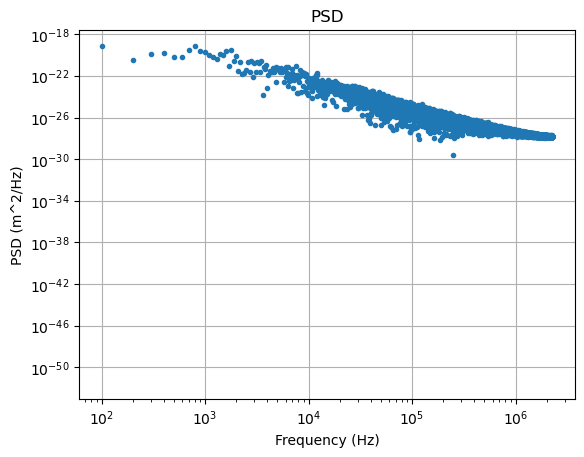

In [31]:
# Check our PSD
import scipy

psds = []
frequency = 0
for trace in traces:
    frequency, psd = scipy.signal.periodogram(trace, fs=fs, scaling="density")
    psds.append(psd)
psd = np.mean(psds, axis=0)
plt.plot(frequency, psd, ".")
# plt.ylim(bottom=1e-29, top=1e-16)
# plt.xlim(left = 100)
# plt.xlim(left=1e4)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (m^2/Hz)")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title("PSD")
plt.show()

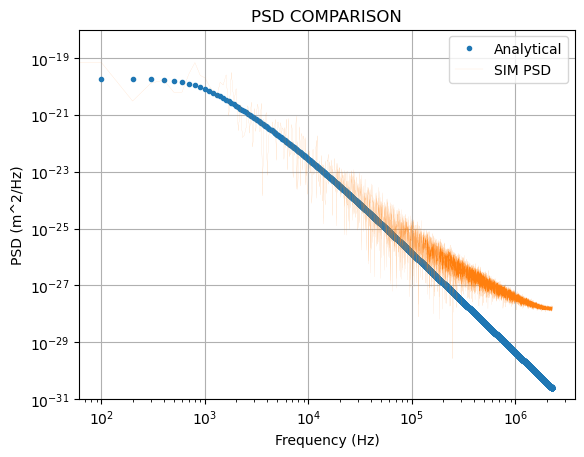

In [32]:
def PSD_standalone(omega):
    # This is the PSD we look to fit.  We fit for 3 parameters
    # Namely, we fit for the trap strength K, the radius of the particle a, and the voltage to position conversion V
    gamma_s = 6 * math.pi * a * eta
    tau_f = rho_acetone * a ** 2 / eta
    numerator = 2 * const.k * temp * gamma_s * (1 + np.sqrt((1 / 2) * omega * tau_f))
    denominator = (mass_total*((K/mass_total)-omega**2) - omega * gamma_s * np.sqrt((1 / 2) * omega * tau_f)) ** 2 + omega ** 2 * gamma_s ** 2 * (
            1 + np.sqrt((1 / 2) * omega * tau_f)) ** 2
    return numerator / denominator

psd_analytical = PSD_standalone(2*math.pi*frequency)

plt.plot(frequency, psd_analytical, ".", label="Analytical")
plt.plot(frequency, psd, label="SIM PSD", linewidth=.05)
plt.ylim(bottom=1e-31, top=1e-18)
# plt.xlim(left = 100)
# plt.xlim(left=1e4)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (m^2/Hz)")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title("PSD COMPARISON")
plt.legend()
plt.show()

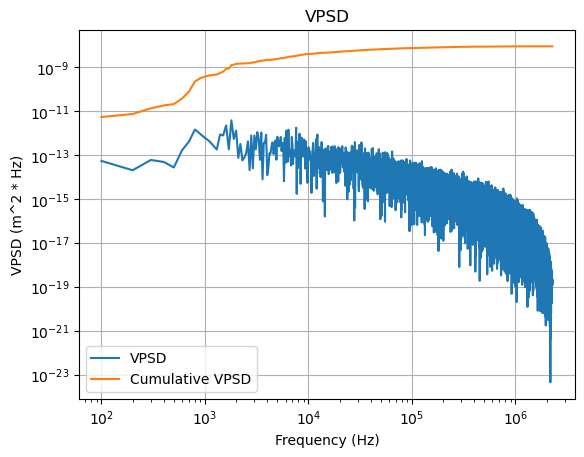

In [33]:
# Check our VPSD
vpsds = []
frequency = 0
for trace in velocity_traces:
# for trace in sim_vel_traces:
    frequency, vpsd = scipy.signal.periodogram(trace, fs=fs, scaling="density")
    vpsds.append(vpsd)
vpsd = np.mean(vpsds, axis=0)
# plt.plot(frequency, vpsd, label = "VPSD")
cumulative_vpsd = np.cumsum(vpsd) * (frequency[1] - frequency[0])  # assuming uniform frequency spacing
# plt.plot(frequency, cumulative_vpsd, label="Cumulative VPSD")
# plt.ylim(bottom=1e-19)
# plt.ylim(top=1e-6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("VPSD (m^2 * Hz)")
plt.title("VPSD")
plt.grid()
#
# vpsd2 = psd*(2*math.pi*frequency)**2
# cumulative_vpsd2 = np.cumsum(vpsd2) * (frequency[1] - frequency[0])  # assuming uniform frequency spacing
plt.plot(frequency[1:], vpsd[1:], label = "VPSD")
plt.plot(frequency[1:], cumulative_vpsd[1:], label="Cumulative VPSD")
plt.legend()
plt.show()

In [34]:
from tqdm import tqdm
def compute_VACF_time_domain(v_series):
    n = len(v_series)
    vacf = np.zeros(n)
    for lag in tqdm(range(n), desc="VACF Compute"):
        vacf[lag] = np.dot(v_series[:n - lag], v_series[lag:]) / (
                n - lag)  # Normalize by number of overlapping terms
    return vacf

all_vacf = []

# CHOOSE SIM VEL OR FINITE DIF FROM SIM POS
# for trace in velocity_traces:
for trace in sim_vel_traces:
    vacf = compute_VACF_time_domain(trace)
    all_vacf.append(vacf)

VACF Compute: 100%|██████████| 45469/45469 [00:01<00:00, 31890.41it/s]


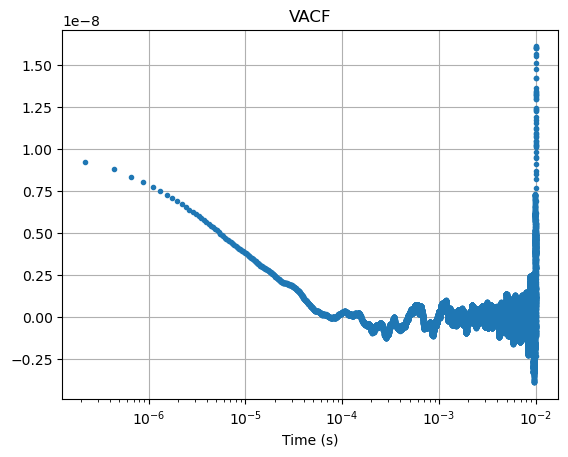

In [35]:
avg_vacf = np.mean(all_vacf, axis=0)

plt.plot(time[1:], avg_vacf, ".")
plt.xscale('log')
# plt.xlim(right=1e-3)
plt.xlabel("Time (s)")
plt.title("VACF")
plt.grid()

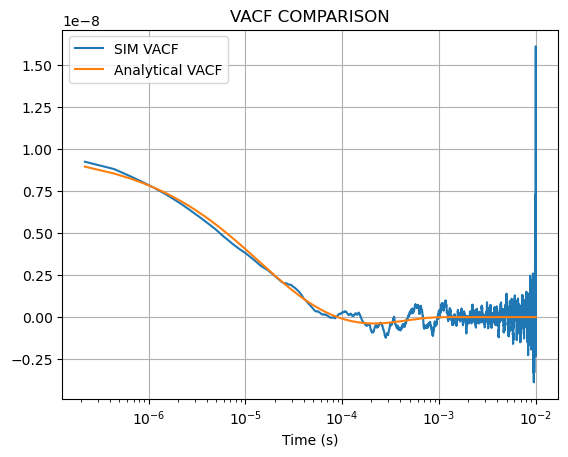

In [36]:
def VACF_fitting_func(t, m, K, r, V_):
    # t = t * (math.pi / 2)
    t_k = (6 * math.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * math.pi * r * eta)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0

    a = t_p + (1 / 9.0) * t_f
    b = -np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a, b, c, d, e]
    # Find the roots

    roots = np.roots(coefficients)

    vacf_complex = (V_)*((const.k * 293) / m) * sum(
        (z ** 3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots
    )
    return np.real(vacf_complex)

vacf_analytical = VACF_fitting_func(time[1:], mass_total, K, a, 1)
plt.plot(time[1:], avg_vacf, label = "SIM VACF")
plt.plot(time[1:], vacf_analytical, label = "Analytical VACF")
plt.xscale('log')
# plt.xlim(right=1e-3)
plt.xlabel("Time (s)")
plt.title("VACF COMPARISON")
plt.legend()
plt.grid()

<>:34: SyntaxWarning: invalid escape sequence '\B'
<>:34: SyntaxWarning: invalid escape sequence '\B'
C:\Users\mcthu\AppData\Local\Temp\ipykernel_28904\2236966645.py:34: SyntaxWarning: invalid escape sequence '\B'
  df.to_csv("..\Brownian_Data_Analysis\scripts\msdarr.csv", index=False)
100%|██████████| 45469/45469 [00:00<00:00, 47146.54it/s]


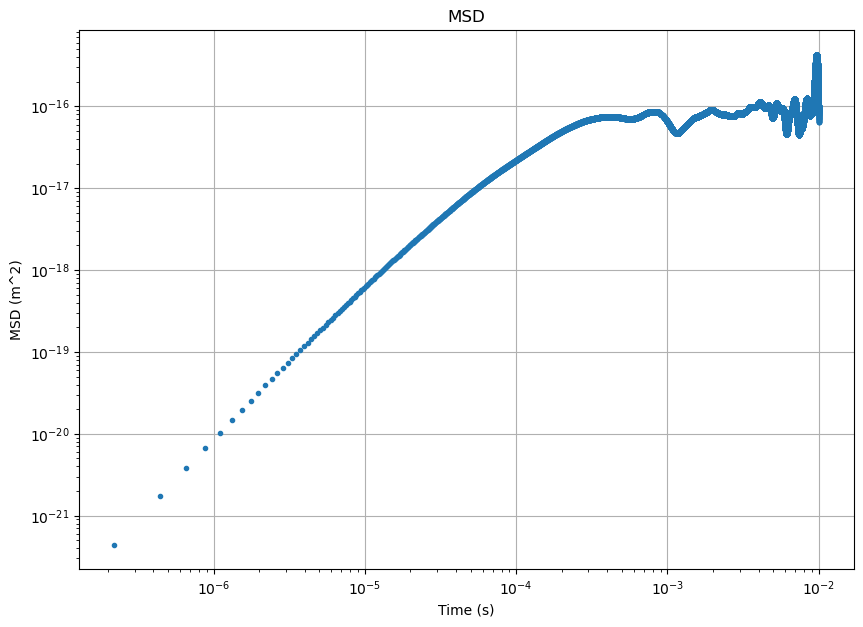

In [37]:
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

all_hp_msd = []
lag_times = 0
for series in traces:
    msd, lag_times = compute_msd(series, real_timestep*bin_num)
    all_hp_msd.append(msd)

hp_avg_msd = np.mean(all_hp_msd, axis=0)


plt.figure(figsize=(10, 7))
plt.plot(lag_times, hp_avg_msd, ".", label='HP Average MSD')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("MSD")
plt.grid(True)

# Create DataFrame with column names
df = pd.DataFrame({"Array1": lag_times, "Array2": hp_avg_msd})

# Save to CSV
df.to_csv("..\Brownian_Data_Analysis\scripts\msdarr.csv", index=False)

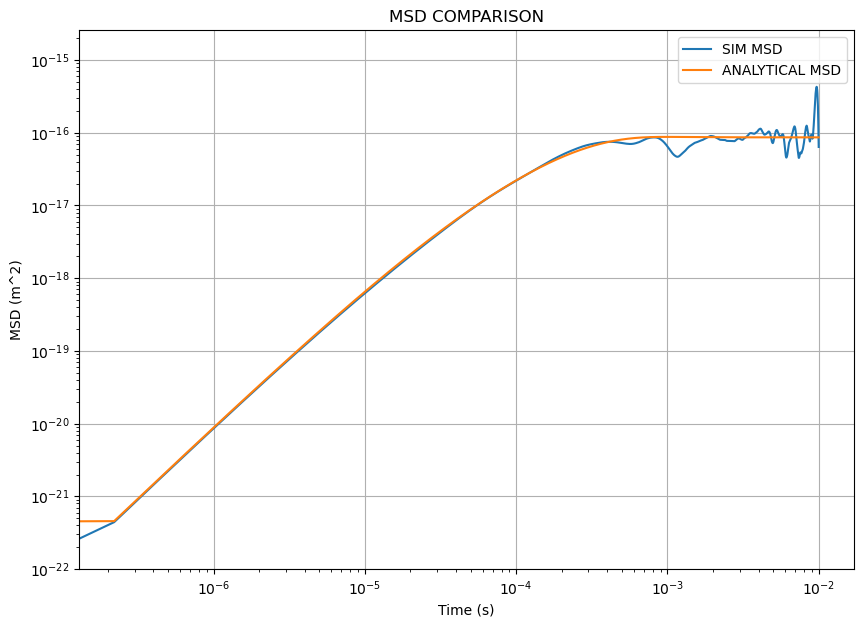

In [38]:
def MSD_fitting_func(t,m, K, r, V):
    trap_const = K
    use_mass = m
    m_f = 4/3*np.pi*r**3*rho_acetone
    t_k = (6 * np.pi * r * eta)/trap_const
    t_f = (rho_acetone*r**2)/eta
    t_p = m/(6 * math.pi * r * eta)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a = t_p
    b = -1*np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    term_1 = scipy.special.erfcx(roots[0]*np.sqrt(t)) / (roots[0]*(roots[0] - roots[1])*(roots[0] - roots[2])*(roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1]*np.sqrt(t)) / (roots[1]*(roots[1] - roots[0])*(roots[1] - roots[2])*(roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2]*np.sqrt(t)) / (roots[2]*(roots[2] - roots[1])*(roots[2] - roots[0])*(roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3]*np.sqrt(t)) / (roots[3]*(roots[3] - roots[1])*(roots[3] - roots[2])*(roots[3] - roots[0]))

    return np.real(V*(2*const.k*temp / trap_const+ 2*const.k*temp/(m)*(term_1+term_2+term_3+term_4)))

msd_analytical = MSD_fitting_func(lag_times, mass_total, K, a, 1)
plt.figure(figsize=(10, 7))
plt.plot(lag_times, hp_avg_msd, label='SIM MSD')
plt.plot(lag_times, msd_analytical, label='ANALYTICAL MSD')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("MSD COMPARISON")
plt.legend()
plt.ylim(bottom=1e-22)
plt.grid(True)